In [1]:
%load_ext autoreload
%autoreload 2

# Generation de courants electriques par les cellules du LGN pour les convertir en spike dans V1

In [2]:
import numpy as np
import Spiking_LGN as SpiLGN
import matplotlib.pyplot as plt

In [3]:
#first we import the video
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

(64, 64, 128)

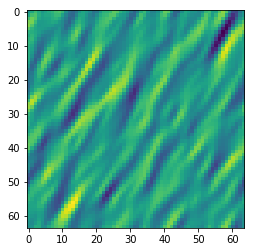

In [4]:
plt.imshow(video[:,:,0])

In [5]:
help(SpiLGN.input_to_currents) #documentation for every function

Help on function input_to_currents in module Spiking_LGN:

input_to_currents(video, FPS, total_time, distrib_size, safeguard_offset, random_shift, grid_res, N_theta, B_theta, sf_0, B_sf, on_thresh, off_thresh, filter_size, filter_res, sampling_rate, n_jobs, backend, mt_verbose, off_gain=1, gabors_params=None, verbose=True, get_coordinates=False)
    Main method, transforms a numpy array input into currents that can be used
    by a spiking neuron simulator (optimized for Nest with PyNN)
    
    Args :
        > Input arguments <
        video : the numpy array input, a video of shape H x W x frames
                the format is for plt.imshow convenience, careful about the H x W order 
        FPS : video's frame per second
        total_time : simulation total time, should you want it shorter than video's length
    
        > Gabor parameters <
        gabors_params : if set to None, the default parameter dictionnary is used
    
        > Generating gabors centers and filters coord

In [6]:
# then we run it into the method, careful here N_theta = 4
output_currents = SpiLGN.input_to_currents(video=video, FPS=24, total_time=1000,
                                           distrib_size=10, safeguard_offset=20, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           off_gain = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

Video shape (64, 64, 128)
Frames per second: 24
Frame duration at 24 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)
Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   43.1s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   44.1s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   44.2s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.0min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  2.4min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  2.4min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  2.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.7min finished


In [7]:
print('Output shape', np.asarray(output_currents).shape)
print('=(Thetas, Gabors, ON/OFF)')

Output shape (12, 16, 2)
=(Thetas, Gabors, ON/OFF)


In [8]:
#We show the second Theta (here pi/4) and third gabor (i.e. simple cell)
theta_display = 1
gabor_display = 3
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]

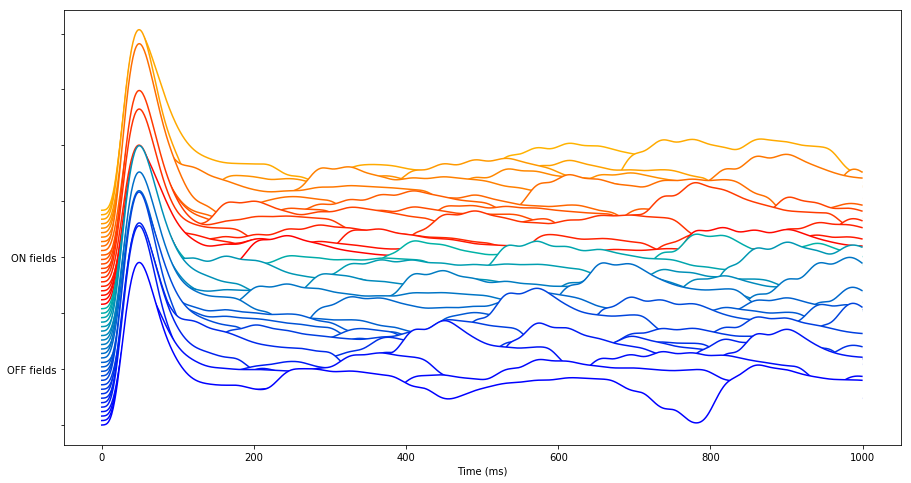

In [9]:
import matplotlib.pyplot as plt
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('white')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 25

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
#plt.savefig('./figs/2018_11_08_Script_output_white.pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

In [10]:
np.asarray(output_currents).shape

(12, 16, 2)

In [11]:
#Now we save the currents, in a numpy compressed array to save space (2.5x less size)
#tradeoff : saving twice as slow
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

In [12]:
#the loading method is a bit different as the npz can dump multiple arrays
load_npz = np.load('./output/%s.npz'%strtime)
load_arr = load_npz['arr_0.npy'] #won't contain more than one array normally

# Visualizing centroids coordinates

Text(0.5, 1.0, 'Centroids distribution\nSome filters are still likely outside the boundaries')

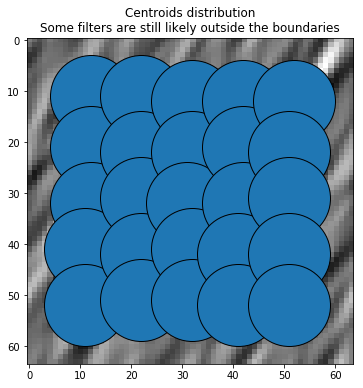

In [13]:
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

coor = SpiLGN.generate_centers_coordinates(
        distrib_size=10, safeguard_offset = 12, random_shift = 1, video=video)


fig = plt.figure(figsize = (8,6))

#la taille des points n'est pas une science exacte
plt.scatter(coor[0], coor[1], s = 82**2, edgecolor = 'black') 


plt.imshow(video[:,:,0], cmap = plt.cm.binary)
plt.title('Centroids distribution\nSome filters are still likely outside the boundaries')